<a href="https://colab.research.google.com/github/vspin25/acute_inflammation/blob/main/Nephritis_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Acute Inflammations (NEPHRITIS)**
Dataset https://archive.ics.uci.edu/dataset/184/acute+inflammations

Libraries

In [ ]:
import pandas as pd
from google.colab import files
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import numpy as np
from sklearn.tree import plot_tree

Dataset

In [ ]:
uploaded = files.upload()

Saving Acute_Inflammations.xlsx to Acute_Inflammations.xlsx


In [ ]:
dataset =pd.read_excel('Acute_Inflammations.xlsx')

# Preprocess

In [ ]:
dataset['temperature']=dataset['temperature'].str.replace(',', '.')

dataset['temperature'] = pd.to_numeric(dataset['temperature'])

print(dataset['temperature'].head())

0    35.5
1    35.9
2    35.9
3    36.0
4    36.0
Name: temperature, dtype: float64


Change temperature to categorical variable

hypothermia: less than 36.2 (not including 36.2)
normal: 36.2-37.4
fever: more than 37.5 (including 37.5)

In [ ]:
bins = [0, 36.2, 37.5, 42]
labels = ['hypothermia', 'normal', 'fever']
dataset['temperature'] = pd.cut(dataset['temperature'], bins=bins, labels=labels, right =False)
print(dataset['temperature'].unique())

['hypothermia', 'normal', 'fever']
Categories (3, object): ['hypothermia' < 'normal' < 'fever']


Create new feature "Symptom count"

In [ ]:
dataset['symptom_count']=dataset[['nausea', 'lumbar-pain', 'urine-pushing','micturition-pains','burning-urethra']].apply(lambda x: (x == 'yes').sum(), axis=1)
print(dataset.head())

   temperature nausea lumbar-pain urine-pushing micturition-pains  \
0  hypothermia     no         yes            no                no   
1  hypothermia     no          no           yes               yes   
2  hypothermia     no         yes            no                no   
3  hypothermia     no          no           yes               yes   
4  hypothermia     no         yes            no                no   

  burning-urethra bladder-inflammation nephritis  symptom_count  
0              no                   no        no              1  
1             yes                  yes        no              3  
2              no                   no        no              1  
3             yes                  yes        no              3  
4              no                   no        no              1  


Encode columns (0,1,2)

In [ ]:
new_label=LabelEncoder()
data_encoded = dataset.copy()

label_mappings ={}

for col in data_encoded.columns:
    new_label.fit(data_encoded[col])
    data_encoded[col] = new_label.fit_transform(data_encoded[col])
    label_mappings[col] = dict(zip(new_label.classes_, new_label.transform(new_label.classes_)))

# Mapping values
for feature, mapping in label_mappings.items():
    print(f"Feature:{feature}")
    print("Original---> Encoded:")
    for original, encoded in mapping.items():
        print(f"  {original} ---> {encoded}")
    print("\n")

Feature:temperature
Original---> Encoded:
  fever ---> 0
  hypothermia ---> 1
  normal ---> 2


Feature:nausea
Original---> Encoded:
  no ---> 0
  yes ---> 1


Feature:lumbar-pain
Original---> Encoded:
  no ---> 0
  yes ---> 1


Feature:urine-pushing
Original---> Encoded:
  no ---> 0
  yes ---> 1


Feature:micturition-pains
Original---> Encoded:
  no ---> 0
  yes ---> 1


Feature:burning-urethra
Original---> Encoded:
  no ---> 0
  yes ---> 1


Feature:bladder-inflammation
Original---> Encoded:
  no ---> 0
  yes ---> 1


Feature:nephritis
Original---> Encoded:
  no ---> 0
  yes ---> 1


Feature:symptom_count
Original---> Encoded:
  0 ---> 0
  1 ---> 1
  2 ---> 2
  3 ---> 3
  4 ---> 4
  5 ---> 5




In [ ]:
print(data_encoded.head())

   temperature  nausea  lumbar-pain  urine-pushing  micturition-pains  \
0            1       0            1              0                  0   
1            1       0            0              1                  1   
2            1       0            1              0                  0   
3            1       0            0              1                  1   
4            1       0            1              0                  0   

   burning-urethra  bladder-inflammation  nephritis  symptom_count  
0                0                     0          0              1  
1                1                     1          0              3  
2                0                     0          0              1  
3                1                     1          0              3  
4                0                     0          0              1  


# Variables

Define target variables

y1 = bladder inflammation

y2 = nephritis

In [ ]:
x = data_encoded.drop(['bladder-inflammation', 'nephritis'], axis=1)
y1 = data_encoded['bladder-inflammation']
y2 = data_encoded['nephritis']

In [ ]:
x_train, x_test, y1_train, y1_test = train_test_split(x, y1, test_size=0.3, random_state=42)
x_train, x_test, y2_train, y2_test = train_test_split(x, y2, test_size=0.3, random_state=42)

In [ ]:
print(f"Training set X:{x_train.shape[0]}")
print(f"Testing set X:{x_test.shape[0]}")
print("\n")

print(f"Training set Y1:{y1_train.shape[0]}")
print(f"Testing set Y1:{y1_test.shape[0]}")
print("\n")

print(f"Training set Y2:{y2_train.shape[0]}")
print(f"Testing set Y2:{y2_test.shape[0]}")
print("\n")

#Features
print(f"Number of features: {x_train.shape[1]}")

Training set X:84
Testing set X:36


Training set Y1:84
Testing set Y1:36


Training set Y2:84
Testing set Y2:36


Number of features: 7


**VARIABLES**

In [ ]:
x=data_encoded.drop(['bladder-inflammation', 'nephritis'], axis=1) #complete data (x)
x_simple= x.drop('symptom_count', axis=1) # complete "x" without symptom count for cross validation
x_simple_train= x_train.drop('symptom_count', axis=1) # x_train set NO symtom count
x_simple_test= x_test.drop('symptom_count', axis=1) # x_test set NO symtom count

y= y2 #Complete data (y)
y_train= y2_train
y_test= y2_test

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'] #list of metrics

# Number of folds = 5
kfold = KFold(n_splits=5, shuffle= True, random_state= 42)

# Random Forest Model 1

**RF model 1 with default parameters (NO symptom count)**

In [ ]:
RF1 = RandomForestClassifier(random_state= 42)

Train using training and testing sets

In [ ]:
RF1.fit(x_simple_train, y_train)

RandomForestClassifier(random_state=42)

Hyperparameters Model 1

In [ ]:
#Number of trees
trees= RF1.n_estimators
print(f"Number of trees: {trees}")

# Samples per tree
samples_tree = x_simple_train.shape[0]
print(f"Number of samples per tree: {samples_tree}")

# Maximum depth
max_depths = [estimator.get_depth() for estimator in RF1.estimators_]
print(f"Maximum depth of each tree: {max_depths}")

#Features
num_features = RF1.n_features_in_
print(f"Number of features used in the Random Forest model: {num_features}")

print(f"Features used for each tree: {RF1.max_features}")

Number of trees: 100
Number of samples per tree: 84
Maximum depth of each tree: [4, 3, 3, 4, 4, 3, 5, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 3, 3, 4, 5, 3, 4, 3, 3, 5, 3, 2, 4, 4, 4, 2, 3, 5, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 4, 2, 5, 4, 4, 5, 3, 4, 4, 4, 4, 4, 4, 5, 3, 4, 4, 5, 4, 4, 2, 3, 3, 3, 4, 2, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 3, 3, 5, 3, 5, 5, 4, 3, 3, 4, 4, 4, 5, 5, 3, 4, 4]
Number of features used in the Random Forest model: 6
Features used for each tree: sqrt


Prediction RF model 1

In [ ]:
y_pred_RF1 = RF1.predict(x_simple_test)

Confusion matrix RF model 1

In [ ]:
print("Confusion Matrix (Model 1):")
print(confusion_matrix(y_test, y_pred_RF1))

Confusion Matrix (Model 1):
[[21  0]
 [ 0 15]]


Accuracy RF model 1

In [ ]:
accuracy_RF1 = accuracy_score(y_test, y_pred_RF1)
print(f"Accuracy Random Forest model1: {accuracy_RF1 *100:.2f}%")


Accuracy Random Forest model1: 100.00%


Using cross validation

In [ ]:
#Metrics
fi_RF1 = [] #Feature importances per fold
accuracy_scores_RF1= []
precision_scores_RF1= []
recall_scores_RF1= []

accuracy_scores_RF1_train = []
precision_scores_RF1_train = []
recall_scores_RF1_train = []

Train model and get metrics per fold

In [ ]:
for train_index_RF1, test_index_RF1 in kfold.split(x_simple):
    xRF1_train_cv, xRF1_test_cv = x_simple.iloc[train_index_RF1], x_simple.iloc[test_index_RF1]
    yRF1_train_cv, yRF1_test_cv = y.iloc[train_index_RF1], y.iloc[test_index_RF1]

    train_size1 = len(train_index_RF1)
    test_size1 = len(test_index_RF1)
    print(f"Training Size: {train_size1}, Testing Size: {test_size1}")

     # Train
    RF1.fit(xRF1_train_cv,yRF1_train_cv)

    y_pred_RF1 = RF1.predict(xRF1_test_cv)
    ytrain_pred_RF1 = RF1.predict (xRF1_train_cv)

    # Metrics for each fold and feature importance
    accuracy_scores_RF1.append(accuracy_score (yRF1_test_cv, y_pred_RF1))
    precision_scores_RF1.append(precision_score (yRF1_test_cv, y_pred_RF1, average='binary'))
    recall_scores_RF1.append(recall_score (yRF1_test_cv, y_pred_RF1, average='binary'))

    fi_RF1.append(RF1.feature_importances_) #feature imp

    # Metrics for each fold (train)
    accuracy_scores_RF1_train.append(accuracy_score(yRF1_train_cv, ytrain_pred_RF1))
    precision_scores_RF1_train.append(precision_score(yRF1_train_cv, ytrain_pred_RF1, average='binary'))
    recall_scores_RF1_train.append(recall_score(yRF1_train_cv, ytrain_pred_RF1, average='binary'))

    print(RF1.get_params())

Training Size: 96, Testing Size: 24
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Training Size: 96, Testing Size: 24
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Training Size: 96, Testing Size: 24
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'cri

Metrics average

In [ ]:
#train
print(f"Mean Accuracy RF 1 test (cross-validation): {np.mean(accuracy_scores_RF1 ) *100:.2f}%")
print(f"Mean Precision RF1 test(Cross-validation): {np.mean(precision_scores_RF1) * 100:.2f}%")
print(f"Mean Recall RF1 test(Cross-validation): {np.mean(recall_scores_RF1) * 100:.2f}%")

Mean Accuracy RF 1 test (cross-validation): 100.00%
Mean Precision RF1 test(Cross-validation): 100.00%
Mean Recall RF1 test(Cross-validation): 100.00%


In [ ]:
#train
print(f"Mean Accuracy RF1 Train(cross-validation): {np.mean(accuracy_scores_RF1_train )* 100:.2f}%")
print(f"Mean Precision RF1 Train(Cross-validation): {np.mean(precision_scores_RF1_train )* 100:.2f}%")
print(f"Mean Recall RF1 Train(Cross-validation): {np.mean(recall_scores_RF1_train)* 100:.2f}%")

Mean Accuracy RF1 Train(cross-validation): 100.00%
Mean Precision RF1 Train(Cross-validation): 100.00%
Mean Recall RF1 Train(Cross-validation): 100.00%


Feature importance values

In [ ]:
fi_RF1 = np.array(fi_RF1)
mean_fi_RF1 = fi_RF1.mean(axis= 0) #Mean feature importance
percent_fi_RF1 = mean_fi_RF1 *100

fi_RF1_df = pd.DataFrame({'Feature': xRF1_train_cv.columns, 'Importance %': percent_fi_RF1})#dataframe fi
fi_RF1_df = fi_RF1_df.sort_values(by= 'Importance %', ascending= False)

print(fi_RF1_df)#print


             Feature  Importance %
2        lumbar-pain     30.244377
1             nausea     23.306985
0        temperature     18.814860
5    burning-urethra     10.436576
4  micturition-pains      9.220402
3      urine-pushing      7.976801


Feature importance graph

<ipython-input-24-567a0a8ab72b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance %', data=fi_RF1_df, palette="coolwarm")


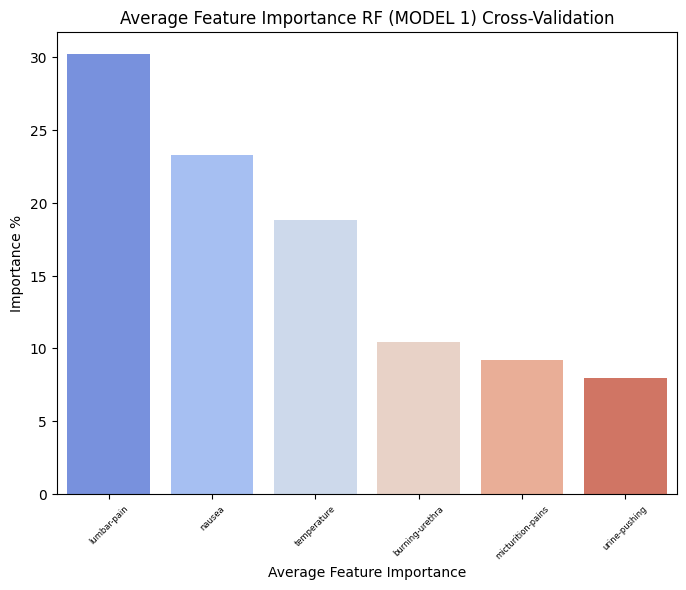

In [ ]:
plt.figure(figsize= (8, 6))
sns.barplot(x='Feature', y='Importance %', data=fi_RF1_df, palette="coolwarm")
#plt.bar(fi_RF1_df['Feature'], fi_RF1_df['Importance %'])
plt.xlabel('Average Feature Importance')
plt.title('Average Feature Importance RF (MODEL 1) Cross-Validation')
plt.xticks(rotation=45)
plt.xticks(fontsize=6)
plt.show()

# Decission Tree model 1

**DT model 1 with default parameters (NO symptom count)**

In [ ]:
DT1= DecisionTreeClassifier(random_state= 42)

Train using training and testing sets

In [ ]:
DT1.fit(x_simple_train, y_train)

DecisionTreeClassifier(random_state=42)

Hyperparameters DT Model 1

In [ ]:
# Samples per tree
samples_tree = x_simple_train.shape[0]
print(f"Number of samples used to train the Decision Tree: {samples_tree}")

# Maximum depth
max_depth = DT1.get_depth()
print(f"Maximum depth of the Decision Tree: {max_depth}")

#Features
num_features = DT1.n_features_in_
print(f"Number of features used in the Decision Tree model: {num_features}")

Number of samples used to train the Decision Tree: 84
Maximum depth of the Decision Tree: 4
Number of features used in the Decision Tree model: 6


Prediction DT model 1

In [ ]:
y_pred_DT1 = DT1.predict (x_simple_test)

Confusion matrix DT model 1

In [ ]:
print("Confusion Matrix (Model 1 DT):")
print(confusion_matrix (y_test, y_pred_DT1))

Confusion Matrix (Model 1 DT):
[[21  0]
 [ 0 15]]


Accuract DT model 1

In [ ]:
accuracy_DT1 = accuracy_score(y_test, y_pred_DT1)
print(f"Accuracy DT model1: {accuracy_DT1 *100:.2f}%")

Accuracy DT model1: 100.00%


Ussing cross validation

In [ ]:
#Metrics
fi_DT1 = [] #Feature importances per fold
accuracy_scores_DT1 = []
precision_scores_DT1 = []
recall_scores_DT1 = []

accuracy_scores_DT1_train = []
precision_scores_DT1_train = []
recall_scores_DT1_train = []

Train model and metrics

In [ ]:
for train_index_DT1, test_index_DT1 in kfold.split (x_simple):
    xDT1_train_cv, xDT1_test_cv = x_simple.iloc[train_index_DT1], x_simple.iloc[test_index_DT1]
    yDT1_train_cv, yDT1_test_cv = y.iloc[train_index_DT1], y.iloc[test_index_DT1]

    # Train
    DT1.fit (xDT1_train_cv, yDT1_train_cv)

    y_pred_DT1 =DT1.predict (xDT1_test_cv)
    ytrain_pred_DT1=DT1.predict(xDT1_train_cv)

    # Metrics for each fold and feature importance
    accuracy_scores_DT1.append(accuracy_score (yDT1_test_cv, y_pred_DT1))
    precision_scores_DT1.append(precision_score (yDT1_test_cv, y_pred_DT1, average='binary'))
    recall_scores_DT1.append(recall_score(yDT1_test_cv, y_pred_DT1, average='binary'))
    fi_DT1.append(DT1.feature_importances_)

    # Metrics for each fold TRAIN
    accuracy_scores_DT1_train.append(accuracy_score (yDT1_train_cv, ytrain_pred_DT1))
    precision_scores_DT1_train.append(precision_score (yDT1_train_cv, ytrain_pred_DT1, average='binary'))
    recall_scores_DT1_train.append(recall_score (yDT1_train_cv, ytrain_pred_DT1, average='binary'))

    print(DT1.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': Non

Metrics Average

In [ ]:
print(f"Mean Accuracy DT 1 (cross-validation): {np.mean(accuracy_scores_DT1 )*100:.2f}%")
print(f"Mean Precision DT 1 (Cross-validation): {np.mean(precision_scores_DT1)* 100:.2f}%")
print(f"Mean Recall DT 1 (Cross-validation): {np.mean(recall_scores_DT1) * 100:.2f}%")

Mean Accuracy DT 1 (cross-validation): 100.00%
Mean Precision DT 1 (Cross-validation): 100.00%
Mean Recall DT 1 (Cross-validation): 100.00%


In [ ]:
#train
print(f"Mean Accuracy DT1 Train(cross-validation): {np.mean(accuracy_scores_DT1_train )* 100:.2f}%")
print(f"Mean Precision DT1 Train(Cross-validation): {np.mean(precision_scores_DT1_train )* 100:.2f}%")
print(f"Mean Recall DT1 Train(Cross-validation): {np.mean(recall_scores_DT1_train)* 100:.2f}%")

Mean Accuracy DT1 Train(cross-validation): 100.00%
Mean Precision DT1 Train(Cross-validation): 100.00%
Mean Recall DT1 Train(Cross-validation): 100.00%


Feature Importance

In [ ]:
fi_DT1 = np.array(fi_DT1)
mean_fi_DT1 = fi_DT1.mean(axis= 0) #Mean feature importance
percent_fi_DT1 = mean_fi_DT1 * 100

fi_DT1_df = pd.DataFrame({'Feature': xDT1_train_cv.columns, 'Importance %':percent_fi_DT1})#dataframe fi
fi_DT1_df = fi_DT1_df.sort_values(by='Importance %', ascending =False)

print(fi_DT1_df)#print

             Feature  Importance %
2        lumbar-pain     51.029782
0        temperature     33.482072
1             nausea     11.282139
3      urine-pushing      4.206007
4  micturition-pains      0.000000
5    burning-urethra      0.000000


<ipython-input-36-361f2efa6a7f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance %', data= fi_DT1_df, palette="coolwarm")


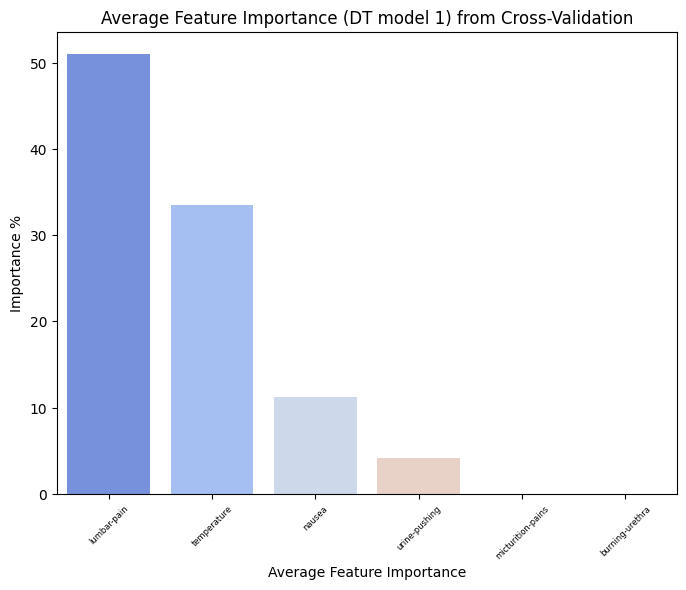

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Feature', y='Importance %', data= fi_DT1_df, palette="coolwarm")

plt.xlabel('Average Feature Importance')
plt.title('Average Feature Importance (DT model 1) from Cross-Validation')
plt.xticks(rotation=45)
plt.xticks(fontsize=6)
plt.show()


# Random Forest Model 2

**RF model 2 parameter tunning (NO symptom count)**

In [ ]:
RF2 = RandomForestClassifier(random_state= 42, n_estimators= 10, max_depth=3, min_samples_split=50, min_samples_leaf =20)

Train using training and testing sets

In [ ]:
RF2.fit(x_simple_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=20, min_samples_split=50,
                       n_estimators=10, random_state=42)

Prediction RF model 2

In [ ]:
y_pred_RF2 = RF2.predict(x_simple_test)

Confusion matrix RF model 2

In [ ]:
print("Confusion Matrix (RF Model 2):")
print(confusion_matrix(y_test, y_pred_RF2))

Confusion Matrix (RF Model 2):
[[21  0]
 [ 0 15]]


Accuracy RF model 2

In [ ]:
accuracy_RF2 = accuracy_score(y_test, y_pred_RF2)
print(f"Accuracy Random Forest model2: {accuracy_RF2 * 100:.2f}%")

Accuracy Random Forest model2: 100.00%


Using cross validation

In [ ]:
# metrics
fi_RF2 = []
accuracy_scores_RF2 = []
precision_scores_RF2 = []
recall_scores_RF2 = []

accuracy_scores_RF2_train = []
precision_scores_RF2_train = []
recall_scores_RF2_train = []

Train model and metrics

In [ ]:
for train_index_RF2, test_index_RF2 in kfold.split(x_simple):
    xRF2_train_cv, xRF2_test_cv = x_simple.iloc[train_index_RF2], x_simple.iloc[test_index_RF2]
    yRF2_train_cv, yRF2_test_cv = y.iloc[train_index_RF2], y.iloc[test_index_RF2]

    train_size = len(train_index_RF2)
    test_size = len(test_index_RF2)
    print(f"Training Size: {train_size}, Testing Size: {test_size}")

    # Train
    RF2.fit(xRF2_train_cv, yRF2_train_cv)

    y_pred_RF2 = RF2.predict(xRF2_test_cv)
    ytrain_pred_RF2 = RF2.predict (xRF2_train_cv)

    # Metrics for each fold TEST
    accuracy_scores_RF2.append(accuracy_score (yRF2_test_cv, y_pred_RF2))
    precision_scores_RF2.append(precision_score(yRF2_test_cv, y_pred_RF2, average='binary'))
    recall_scores_RF2.append (recall_score (yRF2_test_cv, y_pred_RF2, average='binary'))

    # Metrics for each fold and feature importance TRAIN
    accuracy_scores_RF2_train.append(accuracy_score(yRF2_train_cv, ytrain_pred_RF2))
    precision_scores_RF2_train.append(precision_score(yRF2_train_cv, ytrain_pred_RF2, average='binary'))
    recall_scores_RF2_train.append(recall_score(yRF2_train_cv, ytrain_pred_RF2, average='binary'))

    fi_RF2.append (RF2.feature_importances_)

    print(RF2.get_params())

Training Size: 96, Testing Size: 24
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'min_samples_split': 50, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Training Size: 96, Testing Size: 24
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'min_samples_split': 50, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Training Size: 96, Testing Size: 24
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criteri

Metrics Average Train

In [ ]:
print(f"Mean Accuracy RF2 Train(cross-validation): {np.mean(accuracy_scores_RF2_train )* 100:.2f}%")
print(f"Mean Precision RF2 Train(Cross-validation): {np.mean(precision_scores_RF2_train )* 100:.2f}%")
print(f"Mean Recall RF2 Train(Cross-validation): {np.mean(recall_scores_RF2_train)* 100:.2f}%")

Mean Accuracy RF2 Train(cross-validation): 96.04%
Mean Precision RF2 Train(Cross-validation): 95.41%
Mean Recall RF2 Train(Cross-validation): 95.50%


Metrics Average Test

In [ ]:
print(f"Mean Accuracy RF2 (cross-validation): {np.mean(accuracy_scores_RF2 )* 100:.2f}%")
print(f"Mean Precision RF2 (Cross-validation): {np.mean(precision_scores_RF2)* 100:.2f}%")
print(f"Mean Recall RF2 (Cross-validation): {np.mean(recall_scores_RF2)*100:.2f}%")

Mean Accuracy RF2 (cross-validation): 95.00%
Mean Precision RF2 (Cross-validation): 91.72%
Mean Recall RF2 (Cross-validation): 98.00%


Feature Importance

In [ ]:
fi_RF2 = np.array(fi_RF2)
mean_fi_RF2 = fi_RF2.mean(axis=0) #Mean feature importance
percent_fi_RF2 = mean_fi_RF2*100

fi_RF2_df = pd.DataFrame({'Feature': xRF2_train_cv.columns, 'Importance %': percent_fi_RF2})#dataframe fi
fi_RF2_df = fi_RF2_df.sort_values(by='Importance %', ascending=False)

print(fi_RF2_df)#print

             Feature  Importance %
2        lumbar-pain     39.777778
3      urine-pushing     24.444444
4  micturition-pains     12.888889
5    burning-urethra     12.444444
0        temperature     10.444444
1             nausea      0.000000


<ipython-input-70-4394f58e3114>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance %', data= fi_RF2_df, palette="coolwarm")


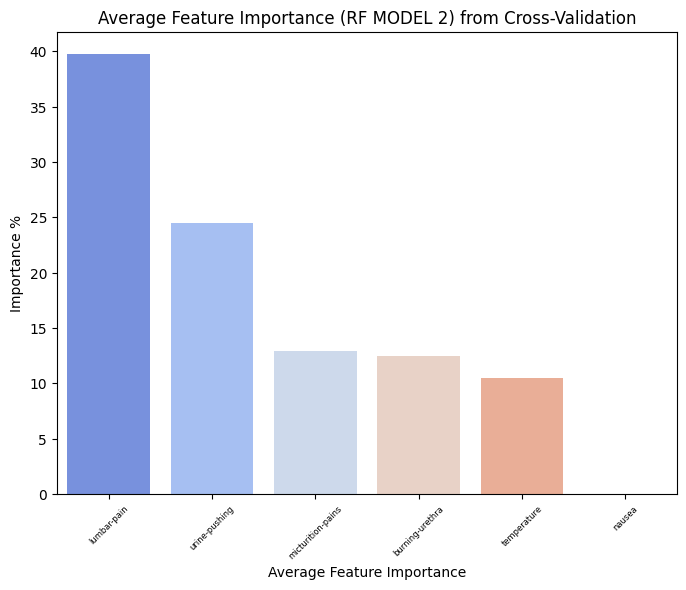

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Feature', y='Importance %', data= fi_RF2_df, palette="coolwarm")

plt.xlabel('Average Feature Importance')
plt.title('Average Feature Importance (RF MODEL 2) from Cross-Validation')
plt.xticks(fontsize=6)
plt.xticks(rotation=45)
plt.show()

# Decission Tree model 2

**DT model 2 parameter tunning (NO symptom count)**

In [ ]:
DT2 = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_split=50, min_samples_leaf=20)

Train using training and testing sets

In [ ]:
DT2.fit(x_simple_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=20, min_samples_split=50,
                       random_state=42)

Prediction DT model 2

In [ ]:
y_pred_DT2 = DT2.predict (x_simple_test)

Confusion Matrix

In [ ]:
print("Confusion Matrix (DT model 2):")
print(confusion_matrix (y_test, y_pred_DT2))

Confusion Matrix (DT model 2):
[[14  7]
 [ 0 15]]


Accuracy

In [ ]:
accuracy_DT2=accuracy_score(y_test, y_pred_DT2)
print(f"Accuracy DT model 2: {accuracy_DT2 * 100:.2f}%")


Accuracy DT model 2: 80.56%


Using Cross Validation

In [ ]:
#Metrics
fi_DT2 = [] #Feature importances per fold
accuracy_scores_DT2 = []
precision_scores_DT2 = []
recall_scores_DT2 = []

accuracy_scores_DT2_train = []
precision_scores_DT2_train = []
recall_scores_DT2_train = []

Train model and metrics

In [ ]:
for train_index_DT2, test_index_DT2 in kfold.split(x_simple):
    xDT2_train_cv, xDT2_test_cv = x_simple.iloc[train_index_DT2], x_simple.iloc[test_index_DT2]
    yDT2_train_cv, yDT2_test_cv = y.iloc[train_index_DT2], y.iloc[test_index_DT2]

    train_size = len(train_index_DT2)
    test_size = len(test_index_DT2)
    print(f"Training Size: {train_size}, Testing Size: {test_size}")

    # Train
    DT2.fit(xDT2_train_cv, yDT2_train_cv)

    y_pred_DT2 = DT2.predict (xDT2_test_cv)
    ytrain_pred_DT2=DT2.predict(xDT2_train_cv)

    # Metrics for each fold
    accuracy_scores_DT2.append (accuracy_score (yDT2_test_cv, y_pred_DT2))
    precision_scores_DT2.append(precision_score (yDT2_test_cv, y_pred_DT2, average='binary'))
    recall_scores_DT2.append (recall_score (yDT2_test_cv, y_pred_DT2, average='binary'))
    fi_DT2.append(DT2.feature_importances_)

    # Metrics for each fold TRAIN and feature importance
    accuracy_scores_DT2_train.append(accuracy_score (yDT2_train_cv, ytrain_pred_DT2))
    precision_scores_DT2_train.append(precision_score (yDT2_train_cv, ytrain_pred_DT2, average='binary'))
    recall_scores_DT2_train.append(recall_score (yDT2_train_cv, ytrain_pred_DT2, average='binary'))

    fi_DT2.append(DT2.feature_importances_)

    print(DT2.get_params())

Training Size: 96, Testing Size: 24
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'min_samples_split': 50, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Training Size: 96, Testing Size: 24
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'min_samples_split': 50, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Training Size: 96, Testing Size: 24
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'min_samples_split': 50, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'be


Metrics Average Train

In [ ]:
print(f"Mean Accuracy DT 2 Train (cross-validation): {np.mean(accuracy_scores_DT2_train)* 100:.2f}%")
print(f"Mean Precision DT 2 Train(Cross-validation): {np.mean(precision_scores_DT2_train)* 100:.2f}%")
print(f"Mean Recall DT 2 Train(Cross-validation): {np.mean(recall_scores_DT2_train) * 100:.2f}%")

Mean Accuracy DT 2 Train (cross-validation): 91.67%
Mean Precision DT 2 Train(Cross-validation): 100.00%
Mean Recall DT 2 Train(Cross-validation): 80.02%



Metrics Average

In [ ]:
print(f"Mean Accuracy DT 2 (cross-validation): {np.mean(accuracy_scores_DT2)* 100:.2f}%")
print(f"Mean Precision DT 2 (Cross-validation): {np.mean(precision_scores_DT2)* 100:.2f}%")
print(f"Mean Recall DT 2 (Cross-validation): {np.mean(recall_scores_DT2)* 100:.2f}%")

Mean Accuracy DT 2 (cross-validation): 91.67%
Mean Precision DT 2 (Cross-validation): 100.00%
Mean Recall DT 2 (Cross-validation): 80.32%


Feature Importance

In [ ]:
fi_DT2 = np.array(fi_DT2)
mean_fi_DT2 = fi_DT2.mean(axis=0) #Mean feature importance
percent_fi_DT2 = mean_fi_DT2*100

fi_DT2_df = pd.DataFrame({'Feature': xDT2_train_cv.columns, 'Importance %': percent_fi_DT2})#dataframe fi
fi_DT2_df = fi_DT2_df.sort_values(by='Importance %', ascending= False)

print(fi_DT2_df)#print

             Feature  Importance %
2        lumbar-pain     66.105875
3      urine-pushing     33.894125
1             nausea      0.000000
0        temperature      0.000000
4  micturition-pains      0.000000
5    burning-urethra      0.000000


<ipython-input-81-881573cfaac4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance %', data= fi_DT2_df, palette="coolwarm")


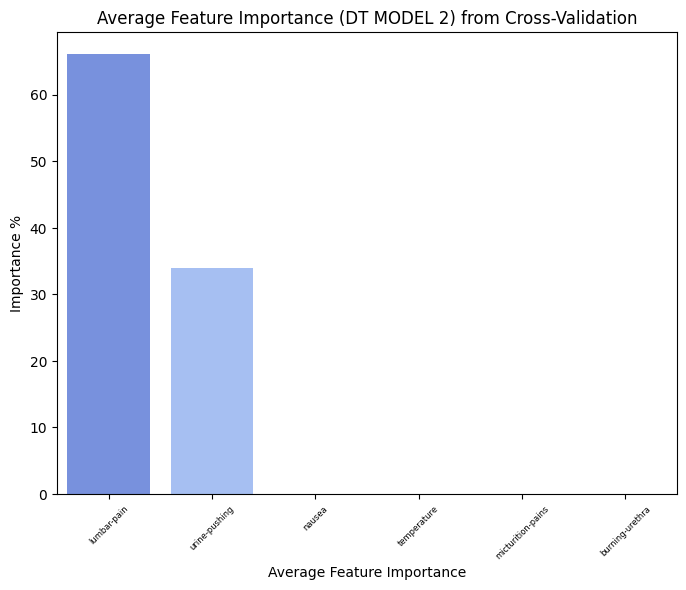

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Feature', y='Importance %', data= fi_DT2_df, palette="coolwarm")
plt.xlabel('Average Feature Importance')
plt.title('Average Feature Importance (DT MODEL 2) from Cross-Validation')
plt.xticks(rotation=45)
plt.xticks(fontsize=6)
plt.show()


# Random Forest Model 3

**RF model 3 parameter tunning (with symptom count)**

In [ ]:
RF3 = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3, min_samples_split=50, min_samples_leaf=20)

Using cross validation

In [ ]:
# metrics
fi_RF3 = []
accuracy_scores_RF3 = []
precision_scores_RF3 = []
recall_scores_RF3 = []

accuracy_scores_RF3_train = []
precision_scores_RF3_train = []
recall_scores_RF3_train = []

Train model and metrics

In [ ]:
for train_index_RF3, test_index_RF3 in kfold.split(x):
    xRF3_train_cv, xRF3_test_cv = x.iloc[train_index_RF3], x.iloc[test_index_RF3]
    yRF3_train_cv, yRF3_test_cv = y.iloc[train_index_RF3], y.iloc[test_index_RF3]

    # Train
    RF3.fit(xRF3_train_cv, yRF3_train_cv)

    y_pred_RF3 = RF3.predict (xRF3_test_cv)
    ytrain_pred_RF3 = RF3.predict (xRF3_train_cv)

    # Metrics for each fold Test
    accuracy_scores_RF3.append(accuracy_score (yRF3_test_cv, y_pred_RF3))
    precision_scores_RF3.append(precision_score(yRF3_test_cv, y_pred_RF3, average='binary'))
    recall_scores_RF3.append(recall_score(yRF3_test_cv, y_pred_RF3, average='binary'))

    # Metrics for each fold and feature importance
    accuracy_scores_RF3_train.append (accuracy_score(yRF3_train_cv, ytrain_pred_RF3))
    precision_scores_RF3_train.append(precision_score(yRF3_train_cv, ytrain_pred_RF3, average='binary'))
    recall_scores_RF3_train.append(recall_score(yRF3_train_cv, ytrain_pred_RF3, average='binary'))

    fi_RF3.append(RF3.feature_importances_)

Metrics Train

In [ ]:
print(f"Mean Accuracy RF3 Train(cross-validation): {np.mean(accuracy_scores_RF3_train )*100:.2f}%")
print(f"Mean Precision RF3 Train(Cross-validation): {np.mean(precision_scores_RF3_train)*100:.2f}%")
print(f"Mean Recall RF3 Train(Cross-validation): {np.mean(recall_scores_RF3_train)*100:.2f}%")

Mean Accuracy RF3 Train(cross-validation): 97.29%
Mean Precision RF3 Train(Cross-validation): 93.97%
Mean Recall RF3 Train(Cross-validation): 100.00%


Metrics Test

In [ ]:
print(f"Mean Accuracy RF3 (cross-validation): {np.mean(accuracy_scores_RF3 )*100:.2f}%")
print(f"Mean Precision RF3 (Cross-validation): {np.mean(precision_scores_RF3)*100:.2f}%")
print(f"Mean Recall RF3 (Cross-validation): {np.mean(recall_scores_RF3)*100:.2f}%")

Mean Accuracy RF3 (cross-validation): 97.50%
Mean Precision RF3 (Cross-validation): 94.85%
Mean Recall RF3 (Cross-validation): 100.00%


Feature Importance

In [ ]:
fi_RF3 = np.array(fi_RF3)
mean_fi_RF3 = fi_RF3.mean(axis=0) #Mean feature importance
percent_fi_RF3 = mean_fi_RF3 * 100

fi_RF3_df = pd.DataFrame({'Feature': xRF3_train_cv.columns, 'Importance %': percent_fi_RF3})#dataframe fi
fi_RF3_df = fi_RF3_df.sort_values(by='Importance %', ascending=False)


print(fi_RF3_df)#print

             Feature  Importance %
6      symptom_count     27.222222
5    burning-urethra     20.555556
2        lumbar-pain     20.555556
0        temperature     15.833333
4  micturition-pains      8.888889
1             nausea      4.444444
3      urine-pushing      2.500000


<ipython-input-88-5c3bc9a88ad3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance %', data= fi_RF3_df, palette="coolwarm")


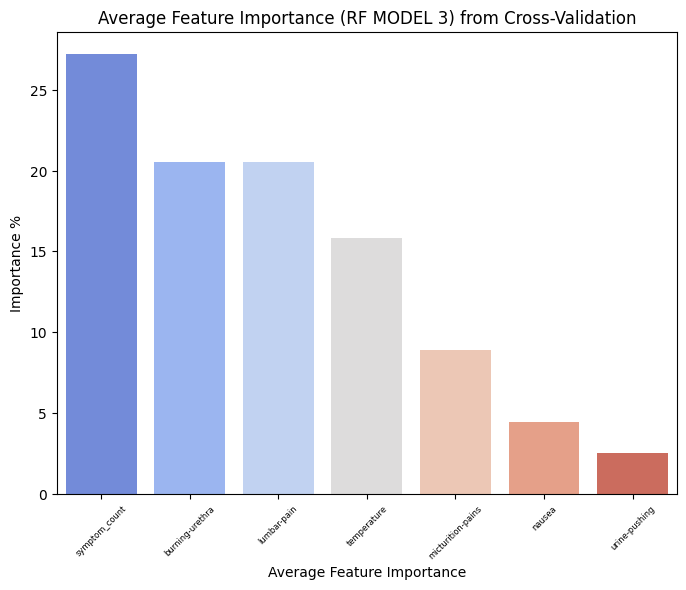

In [ ]:
plt.figure(figsize=(8, 6))

sns.barplot(x='Feature', y='Importance %', data= fi_RF3_df, palette="coolwarm")
plt.xlabel('Average Feature Importance')
plt.title('Average Feature Importance (RF MODEL 3) from Cross-Validation')

plt.xticks(rotation=45)
plt.xticks(fontsize=6)
plt.show()


# Decission Tree Model 3

**DT model 3 parameter tunning (with symptom count)**

In [ ]:
DT3 = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_split=50, min_samples_leaf=20)

Using Cross Validation

In [ ]:
# metrics
fi_DT3 = []
accuracy_scores_DT3 = []
precision_scores_DT3 = []
recall_scores_DT3 = []

accuracy_scores_DT3_train = []
precision_scores_DT3_train = []
recall_scores_DT3_train = []

Train model and metrics

In [ ]:
for train_index_DT3, test_index_DT3 in kfold.split(x):
    xDT3_train_cv, xDT3_test_cv = x.iloc[train_index_DT3], x.iloc[test_index_DT3]
    yDT3_train_cv, yDT3_test_cv = y.iloc[train_index_DT3], y.iloc[test_index_DT3]

    # Train
    DT3.fit(xDT3_train_cv, yDT3_train_cv)

    y_pred_DT3 = DT3.predict(xDT3_test_cv)
    ytrain_pred_DT3 = DT3.predict(xDT3_train_cv)

    # Metrics for each fold and feature importance
    accuracy_scores_DT3.append (accuracy_score(yDT3_test_cv, y_pred_DT3))
    precision_scores_DT3.append (precision_score(yDT3_test_cv, y_pred_DT3, average='binary'))
    recall_scores_DT3.append (recall_score(yDT3_test_cv, y_pred_DT3, average='binary'))

    # Metrics for each fold and feature importance
    accuracy_scores_DT3_train.append (accuracy_score(yDT3_train_cv, ytrain_pred_DT3))
    precision_scores_DT3_train.append (precision_score(yDT3_train_cv, ytrain_pred_DT3, average='binary'))
    recall_scores_DT3_train.append (recall_score(yDT3_train_cv, ytrain_pred_DT3, average='binary'))

    fi_DT3.append(DT3.feature_importances_)


Metrics DT3 Training

In [ ]:
print(f"Mean Accuracy DT3 Training(cross-validation): {np.mean(accuracy_scores_DT3_train )* 100:.2f}%")
print(f"Mean Precision DT3 Training (Cross-validation): {np.mean(precision_scores_DT3_train)* 100:.2f}%")
print(f"Mean Recall DT3 Training (Cross-validation): {np.mean(recall_scores_DT3_train)* 100:.2f}%")

Mean Accuracy DT3 Training(cross-validation): 87.71%
Mean Precision DT3 Training (Cross-validation): 89.36%
Mean Recall DT3 Training (Cross-validation): 85.11%


Metrics DT3 Testing

In [ ]:
print(f"Mean Accuracy DT3 (cross-validation): {np.mean(accuracy_scores_DT3 )* 100:.2f}%")
print(f"Mean Precision DT3 (Cross-validation): {np.mean(precision_scores_DT3)* 100:.2f}%")
print(f"Mean Recall DT3 (Cross-validation): {np.mean(recall_scores_DT3)* 100:.2f}%")

Mean Accuracy DT3 (cross-validation): 81.67%
Mean Precision DT3 (Cross-validation): 85.83%
Mean Recall DT3 (Cross-validation): 77.43%


Feature Importance

In [ ]:
fi_DT3 = np.array(fi_DT3)
mean_fi_DT3 = fi_DT3.mean(axis=0) #Mean feature importance
percent_fi_DT3 = mean_fi_DT3 * 100

fi_DT3_df = pd.DataFrame({'Feature': xDT3_train_cv.columns, 'Importance %': percent_fi_DT3})#dataframe fi
fi_DT3_df = fi_DT3_df.sort_values(by='Importance %', ascending=False)

print(fi_DT3_df )#print

             Feature  Importance %
6      symptom_count      47.98195
2        lumbar-pain      25.81264
3      urine-pushing      14.18736
1             nausea      12.01805
0        temperature       0.00000
4  micturition-pains       0.00000
5    burning-urethra       0.00000


<ipython-input-95-581ff4f797b3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance %', data= fi_DT3_df, palette="coolwarm")


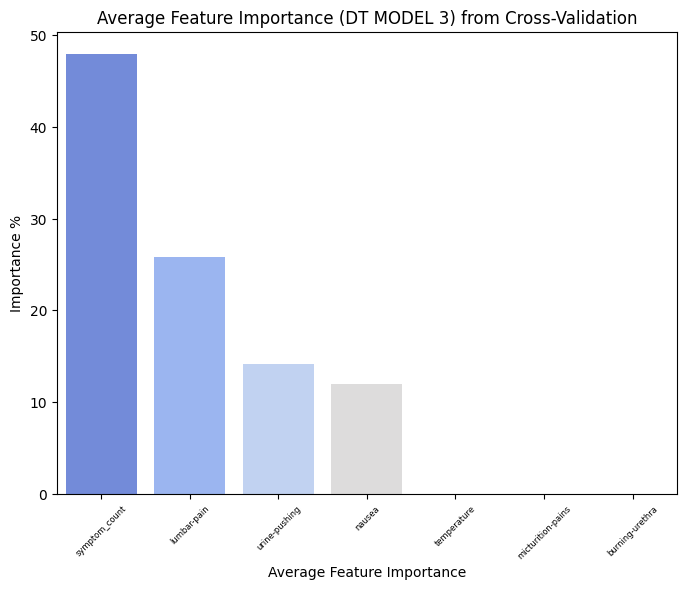

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Feature', y='Importance %', data= fi_DT3_df, palette="coolwarm")
plt.xlabel('Average Feature Importance')
plt.title('Average Feature Importance (DT MODEL 3) from Cross-Validation')

plt.xticks(rotation=45)
plt.xticks(fontsize=6)
plt.show()

print("\n")
print("\n")


# Final Results

Table training

In [ ]:
title1 = "Model Performance (Training)"
print(title1)
print("\n")

# Results
results1 = []

# RF2
results1.append({
    'Model': 'RF2 (Tuned Parameters)',
    'Accuracy': np.mean(accuracy_scores_RF2_train)* 100,
    'Precision': np.mean(precision_scores_RF2_train)* 100,
    'Recall': np.mean(recall_scores_RF2_train) * 100,
    #'F1 Score': np.mean(f1_scores_RF2) * 100,
    #'ROC AUC': np.mean(roc_auc_scores_RF2) * 100
})

# DT2
results1.append({
    'Model': 'DT2 (Tuned Parameters)',
    'Accuracy': np.mean(accuracy_scores_DT2_train)* 100,
    'Precision': np.mean(precision_scores_DT2_train)* 100,
    'Recall': np.mean(recall_scores_DT2_train) * 100,
    #'F1 Score': np.mean(f1_scores_DT2) * 100,
    #'ROC AUC': np.mean(roc_auc_scores_DT2) * 100
})

# RF3
results1.append({
    'Model': 'RF3 (Symptom Count)',
    'Accuracy': np.mean(accuracy_scores_RF3_train)* 100,
    'Precision': np.mean(precision_scores_RF3_train)* 100,
    'Recall': np.mean(recall_scores_RF3_train) * 100,
    #'F1 Score': np.mean(f1_scores_RF3) * 100,
    #'ROC AUC': np.mean(roc_auc_scores_RF3) * 100
})

# DT3
results1.append({
    'Model': 'DT3 (Symptom Count)',
    'Accuracy': np.mean(accuracy_scores_DT3_train)* 100,
    'Precision': np.mean(precision_scores_DT3_train)* 100,
    'Recall': np.mean(recall_scores_DT3_train) * 100,
    #'F1 Score': np.mean(f1_scores_DT3) * 100,
    #'ROC AUC': np.mean(roc_auc_scores_DT3) * 100
})

# dataframe
training_df = pd.DataFrame(results1)

print(training_df)
print("\n")

Model Performance (Training)


                    Model   Accuracy   Precision      Recall
0  RF2 (Tuned Parameters)  96.041667   95.409376   95.500000
1  DT2 (Tuned Parameters)  91.666667  100.000000   80.020013
2     RF3 (Symptom Count)  97.291667   93.973623  100.000000
3     DT3 (Symptom Count)  87.708333   89.360269   85.105378




Table testing

In [ ]:
title = "Model Performance (Testing)"
print(title)
print("\n")

# Results
results = []

# RF2
results.append({
    'Model': 'RF2 (Tuned Parameters)',
    'Accuracy': np.mean(accuracy_scores_RF2)* 100,
    'Precision': np.mean(precision_scores_RF2)* 100,
    'Recall': np.mean(recall_scores_RF2) * 100,
    #'F1 Score': np.mean(f1_scores_RF2) * 100,
    #'ROC AUC': np.mean(roc_auc_scores_RF2) * 100
})

# DT2
results.append({
    'Model': 'DT2 (Tuned Parameters)',
    'Accuracy': np.mean(accuracy_scores_DT2)* 100,
    'Precision': np.mean(precision_scores_DT2)* 100,
    'Recall': np.mean(recall_scores_DT2) * 100,
    #'F1 Score': np.mean(f1_scores_DT2) * 100,
    #'ROC AUC': np.mean(roc_auc_scores_DT2) * 100
})

# RF3
results.append({
    'Model': 'RF3 (Symptom Count)',
    'Accuracy': np.mean(accuracy_scores_RF3)* 100,
    'Precision': np.mean(precision_scores_RF3)* 100,
    'Recall': np.mean(recall_scores_RF3) * 100,
    #'F1 Score': np.mean(f1_scores_RF3) * 100,
    #'ROC AUC': np.mean(roc_auc_scores_RF3) * 100
})

# DT3
results.append({
    'Model': 'DT3 (Symptom Count)',
    'Accuracy': np.mean(accuracy_scores_DT3)* 100,
    'Precision': np.mean(precision_scores_DT3)* 100,
    'Recall': np.mean(recall_scores_DT3) * 100,
    #'F1 Score': np.mean(f1_scores_DT3) * 100,
    #'ROC AUC': np.mean(roc_auc_scores_DT3) * 100
})

# dataframe
testing_df = pd.DataFrame(results)

print(testing_df)
print("\n")

Model Performance (Testing)


                    Model   Accuracy   Precision      Recall
0  RF2 (Tuned Parameters)  95.000000   91.717949   98.000000
1  DT2 (Tuned Parameters)  91.666667  100.000000   80.323232
2     RF3 (Symptom Count)  97.500000   94.848485  100.000000
3     DT3 (Symptom Count)  81.666667   85.833333   77.434343




Create 1 plot containing all plots

<ipython-input-98-075340f8d2cc>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance %', data=fi_DT2_df, ax=axes[0], palette="coolwarm")
<ipython-input-98-075340f8d2cc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance %', data=fi_DT3_df, ax=axes[1], palette="coolwarm")
<ipython-input-98-075340f8d2cc>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance %', data=fi_RF2_df, ax=axes[2], palette="coolwarm")
<ipython-input-98-075340f8d2cc>:21: FutureWarning: 

Passing `pal

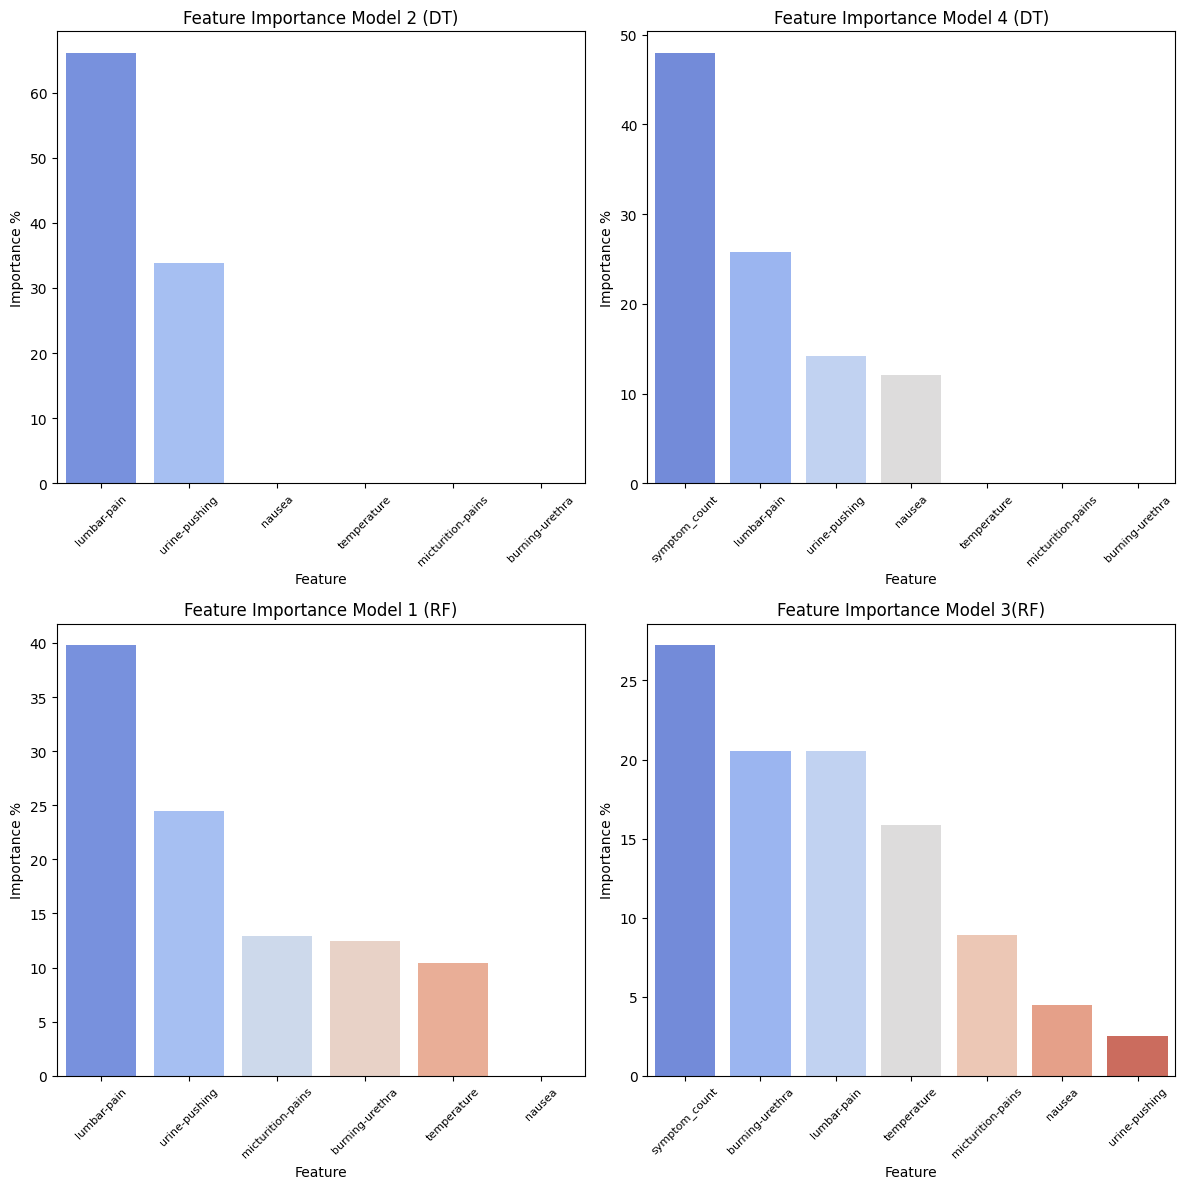

In [ ]:
#Comparing plots with and without symtom count
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# Plot for DT2
sns.barplot(x='Feature', y='Importance %', data=fi_DT2_df, ax=axes[0], palette="coolwarm")
axes[0].set_title('Feature Importance Model 2 (DT)')
axes[0].tick_params(axis='x', rotation=45, labelsize=8)

# Plot for DT3
sns.barplot(x='Feature', y='Importance %', data=fi_DT3_df, ax=axes[1], palette="coolwarm")
axes[1].set_title('Feature Importance Model 4 (DT)')
axes[1].tick_params(axis='x', rotation=45, labelsize=8)

# Plot for RF2
sns.barplot(x='Feature', y='Importance %', data=fi_RF2_df, ax=axes[2], palette="coolwarm")
axes[2].set_title('Feature Importance Model 1 (RF)')
axes[2].tick_params(axis='x', rotation=45, labelsize=8)

# Plot for RF3
sns.barplot(x='Feature', y='Importance %', data=fi_RF3_df, ax=axes[3], palette="coolwarm")
axes[3].set_title('Feature Importance Model 3(RF)')
axes[3].tick_params(axis='x', rotation=45, labelsize=8)

# Final figure
plt.tight_layout()
plt.show()